In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-komputer-if3170/data_train.csv
/kaggle/input/data-komputer-if3170/data_validation.csv
/kaggle/input/data-komputer-if3170/test.csv


# Setup

In [2]:
train_df = pd.read_csv("/kaggle/input/data-komputer-if3170/data_train.csv")
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [3]:
validation_df = pd.read_csv("/kaggle/input/data-komputer-if3170/data_validation.csv")
validation_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
596,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
597,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
598,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [4]:
test_df = pd.read_csv("/kaggle/input/data-komputer-if3170/test.csv")
test_df

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,0,1076,1,2.2,0,3,1,53,0.1,114,...,6,127,1314,1003,16,9,10,1,0,0
1,1,1310,0,2.4,0,0,0,40,0.5,118,...,0,1499,1687,3348,9,2,13,0,0,1
2,2,1915,0,1.1,0,6,0,30,0.6,181,...,8,266,1754,3815,13,4,7,0,0,0
3,3,587,0,1.4,0,9,1,8,0.5,142,...,13,128,593,3182,9,7,10,1,0,0
4,4,1526,0,1.8,0,5,1,11,0.1,131,...,7,150,1606,706,18,7,18,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1841,0,0.9,0,0,1,13,0.6,112,...,3,1311,1679,1645,15,9,12,1,1,1
1996,1996,1064,1,1.8,1,0,0,12,0.3,147,...,5,105,717,1509,16,10,14,0,0,0
1997,1997,1448,0,1.4,1,0,0,22,0.2,142,...,5,345,652,3807,11,7,9,0,0,0
1998,1998,1085,0,2.4,0,3,1,38,0.7,116,...,8,121,905,885,18,4,8,1,0,0


In [5]:
remove_col = [
# 'battery_power',
 'clock_speed',
#  'fc',
 'int_memory',
 'm_dep',
 'mobile_wt',
 'n_cores',
 'pc',
#  'px_height',
#  'px_width',
#  'ram',
 'sc_h',
]
# remove_col = []

In [6]:
non_numeric_columns = ["blue","wifi","touch_screen", "three_g", "dual_sim"]
drop_col = non_numeric_columns.copy()
drop_col.append("price_range")
numeric_columns = train_df.drop(drop_col, axis=1).columns.tolist()
# numeric_columns.remove("fc")
# numeric_columns.remove(remove_col)
for el in remove_col:
    numeric_columns.remove(el)
    
numeric_columns

['battery_power',
 'fc',
 'four_g',
 'px_height',
 'px_width',
 'ram',
 'sc_w',
 'talk_time']

# Data Preprocessing
Dari analisis EDA yang dilakukan akan dilakukan data preprocessing untuk melakukan pelatihan model

## Removing Outliers

Remove outliers using IQR

In [7]:
class OutlierRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.lower_bounds = {}
        self.upper_bounds = {}
        
    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns

        for column in self.columns:
            q3 = X[column].quantile(q=0.75)
            q1 = X[column].quantile(q=0.25)
            IQR = q3 - q1
            lower_bound = q1 - 1.5 * IQR
            upper_bound = q3 + 1.5 * IQR
            
            self.lower_bounds[column] = lower_bound
            self.upper_bounds[column] = upper_bound
        
        return self
    
    def transform(self, X):
        for column in self.columns:
            X = X[(X[column] >= self.lower_bounds[column]) & (X[column] <= self.upper_bounds[column])]
        return X

## Invalid Data Filling

Invalid data will be filled with median using interpolation

In [8]:
class InvalidReplacement(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.median = X['px_height'].median()
        self.columns = X.columns
        return self
    
    def transform(self, X):
        X_ = X.copy()
#         for col in self.columns:
#             if col != 'price_range':
#                 X_[col] = X_[col].replace(0, X_[col].median())
#         X_['px_height'] = X_['px_height'].replace(0, X_['px_height'].mean())
        for index, row in X_.iterrows():
            height = row['px_height']
            width = row['px_width']

            if width == 0 or height / width > 3:
                X_.at[index, 'px_width'] = height/3
            elif height == 0 or width / height > 3:
                X_.at[index, 'px_height'] = width/3

        return X_

## Feature Selection
Remove fc column because it correlates the highest with pc

In [9]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.drop(columns = self.column)
        return X_

## Scaling and Normalizing
Scale values of numeric columns minus column`fc`

In [10]:
# log transform
def log_transform(data):
    return np.log1p(data)

# square root transform
def sqrt_transform(data):
    return data**(1/2)

## Screen Area
Calculating screen resolution from px_height * px_width

In [11]:
class PixelAreaCalculator(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        X_['px_area'] = X['px_height'] * X['px_width']
        return X_

In [12]:
numericTransformation = ColumnTransformer(
    transformers = [
#         ('scaling', StandardScaler(), ['sc_h'])
#         ('normalizing', Normalizer(), ['px_height'])
#         ('log_transform', FunctionTransformer(log_transform, validate=False), ['mobile_wt'])
#         ('sqrt_transform', FunctionTransformer(sqrt_transform, validate=False), ['sc_h', 'mobile_wt']),
    ],
    remainder = 'passthrough'
)

In [13]:
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [14]:
# battery power
invalid_battery_power = train_df[train_df['battery_power'] <= 0]
print(invalid_battery_power)

# Clock Speed
max_realistic_clock_speed = 3.0
invalid_clock_speed = train_df[(train_df['clock_speed'] < 0) | (train_df['clock_speed'] > max_realistic_clock_speed)]
print(invalid_clock_speed)

# Memory
invalid_int_memory = train_df[train_df['int_memory'] < 0]
print(invalid_int_memory)

# Mobile Weight
invalid_mobile_weight = train_df[train_df['mobile_wt'] < 0]
print(invalid_mobile_weight)

# Camera Resolution
invalid_camera_resolution = train_df[(train_df['fc'] < 0) | (train_df['pc'] < 0)]
print(invalid_camera_resolution)

# Pixel Resolution
invalid_pixel_resolution = train_df[(train_df['px_height'] < 0) | (train_df['px_width'] < 0)]
print(invalid_pixel_resolution)

# RAM
invalid_ram = train_df[train_df['ram'] < 0]
print(invalid_ram)

# Screen Dimensions
invalid_screen_dimensions = train_df[(train_df['sc_h'] < 0) | (train_df['sc_w'] < 0)]
print(invalid_screen_dimensions)

# Talk Time
invalid_talk_time = train_df[train_df['talk_time'] < 0]
print(invalid_talk_time)

Empty DataFrame
Columns: [battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, talk_time, three_g, touch_screen, wifi, price_range]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, talk_time, three_g, touch_screen, wifi, price_range]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, talk_time, three_g, touch_screen, wifi, price_range]
Index: []

[0 rows x 21 columns]
Empty DataFrame
Columns: [battery_power, blue, clock_speed, dual_sim, fc, four_g, int_memory, m_dep, mobile_wt, n_cores, pc, px_height, px_width, ram, sc_h, sc_w, talk_time, three_g, touch_screen, wifi, price_range]
Index: []

[0 rows x 21 columns]
Empt

In [15]:
# Drop rows where sc_w is 0
train_df = train_df[train_df['sc_w'] != 0]

In [16]:
# Calculate screen ratio
train_df['screen_ratio'] = train_df['sc_h'] / train_df['sc_w']

# Check for extreme screen ratios
invalid_screen_ratio = train_df[(train_df['screen_ratio'] < 0.5) | (train_df['screen_ratio'] > 3.0)]
print(invalid_screen_ratio)

# Drop the temporary 'screen_ratio' column
train_df.drop(columns=['screen_ratio'], inplace=True)

      battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  \
5               508     1          1.3         0   1       0          50   
6               851     0          2.3         1   7       1          54   
7              1895     0          0.5         0   2       1           5   
19             1350     1          0.5         1   0       1          50   
23             1034     0          2.6         1   2       1          45   
...             ...   ...          ...       ...  ..     ...         ...   
1383            598     1          0.8         1   8       1          62   
1389           1587     1          0.5         0   0       0          50   
1391            803     1          2.1         0   7       0          17   
1393            627     1          1.6         1   3       1          12   
1397           1179     1          0.5         0   7       1          32   

      m_dep  mobile_wt  n_cores  ...  px_width   ram  sc_h  sc_w  talk_time  \
5       

/tmp/ipykernel_20/446337115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['screen_ratio'] = train_df['sc_h'] / train_df['sc_w']
/tmp/ipykernel_20/446337115.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['screen_ratio'], inplace=True)


In [17]:
train_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
5,508,1,1.3,0,1,0,50,0.7,82,5,...,102,1195,2175,14,4,14,0,0,1,1
6,851,0,2.3,1,7,1,54,1.0,101,2,...,788,1007,1005,12,2,14,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


## Pipeline
Pipeline for all preprocessing

In [18]:
train_df.dtypes

battery_power      int64
blue               int64
clock_speed      float64
dual_sim           int64
fc                 int64
four_g             int64
int_memory         int64
m_dep            float64
mobile_wt          int64
n_cores            int64
pc                 int64
px_height          int64
px_width           int64
ram                int64
sc_h               int64
sc_w               int64
talk_time          int64
three_g            int64
touch_screen       int64
wifi               int64
price_range        int64
dtype: object

In [19]:
remove_col

['clock_speed', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'sc_h']

In [20]:
numeric_columns

['battery_power',
 'fc',
 'four_g',
 'px_height',
 'px_width',
 'ram',
 'sc_w',
 'talk_time']

In [21]:
non_numeric_columns

['blue', 'wifi', 'touch_screen', 'three_g', 'dual_sim']

In [22]:
pipeline = Pipeline([
    ('removing outliers', OutlierRemoval(columns=numeric_columns)),
    ('invalid data replacement', InvalidReplacement()),
#     ('pixel area calculation', PixelAreaCalculator()),
    ('feature selection', DropColumn(non_numeric_columns + remove_col))
])

full_pipeline = Pipeline([
    ('preprocessor', pipeline),
#     ('scaling', numericTransformation)
])

transformed_column_names = ['battery_power', 'ram', 'px_width','px_height']
processed_data = full_pipeline.fit_transform(train_df)
print(processed_data.shape)
processed_df = processed_data.copy()
# numeric_columns.remove("fc")
# numeric_columns.remove('sc_h')
# numeric_columns.remove('mobile_wt')
# processed_df = pd.DataFrame(processed_data, columns = train_df.columns)
# processed_df = pd.DataFrame(processed_data, columns = train_df.columns)
processed_df

(1252, 9)


,battery_power,fc,four_g,px_height,px_width,ram,sc_w,talk_time,price_range
0,804,12,1,709.000000,818,2027,5,11,1
2,1481,0,0,249.000000,522,2635,16,4,2
4,652,1,0,464.000000,781,565,12,9,0
5,508,1,0,398.333333,1195,2175,4,14,1
6,851,7,1,788.000000,1007,1005,2,14,0
...,...,...,...,...,...,...,...,...,...
1395,536,0,1,547.000000,705,1211,10,7,0
1396,1097,10,1,1277.000000,1352,2219,6,12,2
1397,1179,7,1,483.666667,1451,340,5,16,0
1398,719,0,1,575.666667,1727,3990,9,12,3


In [23]:
# fig, ax = plt.subplots(5, 3, figsize = (10,10))

# for i, col in enumerate(processed_df.columns):
#     r = i // 3
#     c = i % 3
    
#     sns.histplot(kde=True,data=processed_df[col], ax=ax[r,c])    
#     ax[r, c].set_title(f'Distribution of {col}')
#     ax[r, c].set_xlabel(col)
#     ax[r, c].set_ylabel("Frequency")
    
# plt.tight_layout()
# plt.show()

# Split Data

In [24]:
y_train = processed_df['price_range']
X_train = processed_df.drop(columns=['price_range'])

In [25]:
# transformed_column_names

In [26]:
# scaling_test = numericTransformation.fit_transform(validation_df.drop(columns="fc"))

# transformed_column_names = numeric_columns + [col for col in train_df.columns if col not in numeric_columns and col != 'fc']

# scaled_test = pd.DataFrame(scaling_test, columns = transformed_column_names)
pipeline = Pipeline([
#     ('removing outliers', OutlierRemoval(columns=numeric_columns)),
    ('invalid data replacement', InvalidReplacement()),
#     ('pixel area calculation', PixelAreaCalculator()),
    ('feature selection', DropColumn(non_numeric_columns + remove_col))
])

full_pipeline = Pipeline([
    ('preprocessor', pipeline),
#     ('scaling', numericTransformation)
])
validation_tf = full_pipeline.fit_transform(validation_df)
# processed_tf_df = pd.DataFrame(validation_tf, columns = train_df.columns)
# processed_tf_df = pd.DataFrame(validation_tf, columns = train_df.columns)
processed_tf_df = validation_tf.copy()
y_val = processed_tf_df['price_range']
X_val = processed_tf_df.drop(columns=["price_range"])
X_val

,battery_power,fc,four_g,px_height,px_width,ram,sc_w,talk_time
0,842,1,0,252.000000,756,2549,7,19
1,563,2,1,1263.000000,1716,2603,2,9
2,769,0,0,291.333333,874,3946,2,7
3,775,3,0,862.000000,1864,568,15,11
4,595,7,1,441.000000,810,3752,2,18
...,...,...,...,...,...,...,...,...
595,1547,2,0,347.000000,957,1620,2,19
596,1882,11,1,247.666667,743,3579,8,20
597,674,1,0,603.000000,1809,1180,3,4
598,1965,0,0,915.000000,1965,2032,10,16


In [27]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Using KNN by melihatA

### Modelling

In [28]:
import numpy as np
class KNN_Model():
    # Constructor
    # Define the number of neighbors to use in prediction
    # Default neighbors = 5
    def __init__(self, k=3, dist=1, weights="uniform"):
        self.k = k
        self.dist = dist
        self.weights = weights
    
    # Fit Method
    # Fit the training dataset to the model
    # X are the features, Y is the target
    def fit(self, X, y):
        self.features = X.columns
        self.X_train = X.to_numpy()
        self.y_train = y.to_numpy()
    
    # Predict Method
    # Prediction using KNN Algorithm
    # X is the data to be predicted
    # Return Predicted Data
    def __predict(self, X):
        if (self.dist == 1):
            distances = [self.__euclidean_distance(X, train) for train in self.X_train]
        else:
            # other distance e.g. : Manhattan
            distances = [self.__manhattan_distance(X, train) for train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = None
        if(self.weights == "uniform"):
            most_common = np.bincount(k_nearest_labels)
        elif(self.weights == "distance"):
            weights = 1 / (np.array(distances) + 1e-10)
            chosen_weights = [weights[i] for i in k_indices]
            most_common = np.bincount(k_nearest_labels, weights=chosen_weights)
        return np.argmax(most_common)

    
    def predict(self, X):
        X_ = X.to_numpy()
        result = [self.__predict(test) for test in X_]
        return np.array(result)
    
    # Distance Method for KNN
    def __euclidean_distance(self,p1,p2):
        p1_numeric = np.array(p1, dtype=float)
        p2_numeric = np.array(p2, dtype=float)
        return np.sqrt(np.sum((p1_numeric - p2_numeric) ** 2))
    
    def __manhattan_distance(self, p1, p2):
        p1_numeric = np.array(p1, dtype=float)
        p2_numeric = np.array(p2, dtype=float)
        return np.abs(p1_numeric - p2_numeric)

In [29]:
X_train.shape

(1252, 8)

In [30]:
knn = KNN_Model(k=5, weights="distance")
knn.fit(X_train, y_train)

In [31]:
# knn = KNeighborsClassifier()

# param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
#                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#                   'leaf_size': [10, 20, 30, 40, 50],
#                   'weights': ['distance']}

# scorer = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scorer)

# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)

# best_knn_model = grid_search.best_estimator_

In [32]:
# knn = KNN_Model()

# param_grid = {'k': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49], 'dist': [1, 2]}

# scorer = make_scorer(lambda y_true, y_pred: np.mean(y_true == y_pred))

# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring=scorer)

# grid_search.fit(X_train, y_train)

# print("Best parameters:", grid_search.best_params_)

# best_knn_model = grid_search.best_estimator_

In [33]:
X_val

,battery_power,fc,four_g,px_height,px_width,ram,sc_w,talk_time
0,842,1,0,252.000000,756,2549,7,19
1,563,2,1,1263.000000,1716,2603,2,9
2,769,0,0,291.333333,874,3946,2,7
3,775,3,0,862.000000,1864,568,15,11
4,595,7,1,441.000000,810,3752,2,18
...,...,...,...,...,...,...,...,...
595,1547,2,0,347.000000,957,1620,2,19
596,1882,11,1,247.666667,743,3579,8,20
597,674,1,0,603.000000,1809,1180,3,4
598,1965,0,0,915.000000,1965,2032,10,16


In [34]:
X_train

,battery_power,fc,four_g,px_height,px_width,ram,sc_w,talk_time
0,804,12,1,709.000000,818,2027,5,11
2,1481,0,0,249.000000,522,2635,16,4
4,652,1,0,464.000000,781,565,12,9
5,508,1,0,398.333333,1195,2175,4,14
6,851,7,1,788.000000,1007,1005,2,14
...,...,...,...,...,...,...,...,...
1395,536,0,1,547.000000,705,1211,10,7
1396,1097,10,1,1277.000000,1352,2219,6,12
1397,1179,7,1,483.666667,1451,340,5,16
1398,719,0,1,575.666667,1727,3990,9,12


### Prediction

In [35]:
y_pred_knn = knn.predict(X_val)

### Evaluation

In [36]:
acc = np.sum(y_val == y_pred_knn)/len(y_val)
print(f"Accuracy Percentage {np.round(acc*100,2)}")

Accuracy Percentage 92.67


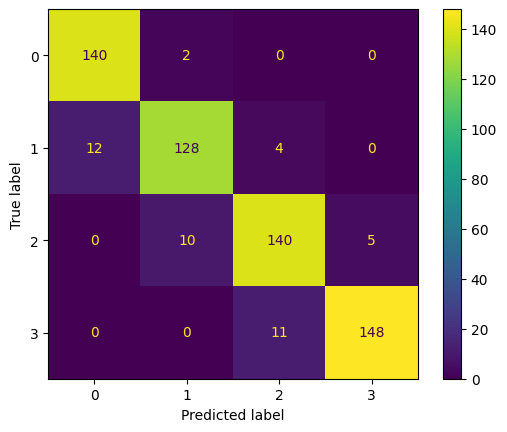

In [37]:
knn_cm = confusion_matrix(y_val, y_pred_knn)
disp = ConfusionMatrixDisplay(knn_cm)
disp.plot()
plt.show()

In [38]:
joblib.dump(knn, "/kaggle/working/knn.pkl")

['/kaggle/working/knn.pkl']

## Using Scikit KNN

### Model

In [39]:
scikit_knn = KNeighborsClassifier(n_neighbors = 3, weights="distance")
scikit_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

### Prediction

In [40]:
y_pred = scikit_knn.predict(X_val)

In [41]:
y_pred = scikit_knn.predict(X_val)
y_pred

array([1, 2, 3, 0, 2, 1, 2, 0, 3, 2, 3, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 2,
       0, 1, 2, 0, 3, 1, 0, 3, 1, 3, 3, 0, 2, 3, 1, 3, 2, 1, 0, 2, 0, 2,
       2, 1, 1, 2, 2, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 1, 3, 3, 1, 3, 2,
       3, 2, 3, 3, 2, 3, 1, 0, 1, 2, 0, 2, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 2, 1, 3, 2, 0, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 3,
       2, 3, 2, 2, 3, 1, 0, 2, 1, 3, 1, 2, 2, 3, 2, 0, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 2, 3, 0, 1, 3, 3, 1, 2, 3, 1, 2, 1, 2, 3, 0, 0, 2,
       1, 1, 2, 0, 1, 3, 3, 3, 0, 2, 3, 0, 0, 1, 0, 2, 2, 1, 0, 1, 1, 1,
       3, 1, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 3, 2, 1, 0, 2, 0, 1, 3,
       3, 1, 1, 2, 2, 3, 2, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 3, 0, 0, 2,
       2, 1, 2, 3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 2, 3, 0, 2, 3, 3, 3, 0, 0,
       1, 0, 3, 3, 1, 1, 0, 2, 2, 1, 3, 3, 0, 1, 2, 0, 0, 1, 0, 2, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 1, 3, 2, 2, 2, 0, 1, 0, 2, 1, 0,
       0, 0, 3, 1, 3, 0, 1, 0, 1, 3, 3, 2, 0, 3, 1,

### Evaluation

In [42]:
acc = np.sum(y_val == y_pred)/len(y_val)
print(f"Accuracy Percentage {np.round(acc*100,2)}")

Accuracy Percentage 92.33


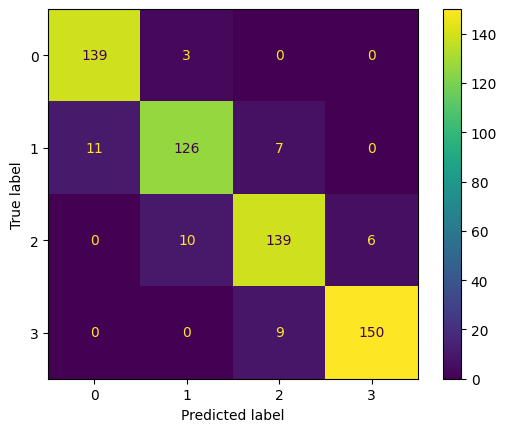

In [43]:
knn_cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(knn_cm)
disp.plot()
plt.show()

### Saving Model

In [44]:
joblib.dump(scikit_knn, "/kaggle/working/scikit_knn.pkl")

['/kaggle/working/scikit_knn.pkl']

## Using Naive Bayes by MelihatA

### Model

In [45]:
import numpy as np
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)
            

    def predict(self, X):
        y_pred = [self._predict(test) for test in np.array(X)]
        return np.array(y_pred)

    def _predict(self, test):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, test)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [46]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

### Prediction

In [47]:
y_pred_nb = nb.predict(X_val)
y_pred_nb

array([2, 2, 3, 0, 3, 1, 3, 0, 3, 1, 2, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 1,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 3, 3, 1, 2, 3, 2, 3, 1, 1, 0, 2, 0, 2,
       2, 1, 1, 2, 1, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 2, 2, 3, 2, 0, 3, 1, 3, 1, 2, 2, 3, 2, 1, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 1, 3, 0, 1, 3, 3, 1, 2, 3, 1, 2, 1, 2, 3, 1, 0, 2,
       1, 0, 3, 0, 0, 3, 3, 3, 0, 2, 3, 0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 1,
       3, 0, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 1, 0, 3, 2, 0, 1, 2, 0, 1, 3,
       3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 0, 2, 0, 2, 3, 1, 2, 3, 2, 0, 0, 2,
       2, 2, 3, 3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 1, 3, 0, 1, 3, 3, 3, 0, 0,
       1, 1, 3, 3, 2, 2, 0, 2, 1, 2, 3, 3, 0, 2, 1, 1, 1, 2, 0, 2, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 2, 2, 2, 0, 1, 0, 1, 1, 1,
       0, 0, 3, 1, 3, 0, 1, 0, 1, 3, 3, 2, 0, 2, 1,

### Evaluation

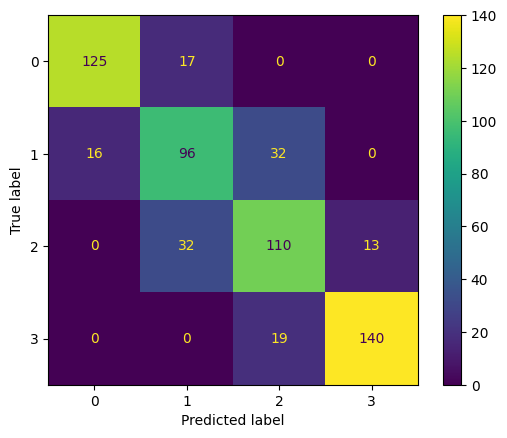

In [48]:
nb_cm = confusion_matrix(y_val, y_pred_nb)
disp = ConfusionMatrixDisplay(nb_cm)
disp.plot()
plt.show()

In [49]:
acc = np.sum(y_val == y_pred_nb)/len(y_val)
print(f"Accuracy Percentage {np.round(acc*100,2)}")

Accuracy Percentage 78.5


### Saving Model

In [50]:
joblib.dump(nb, "/kaggle/working/naive_bayes.pkl")

['/kaggle/working/naive_bayes.pkl']

## Using Scikit Naive Bayes

### Model

In [51]:
scikit_nb = GaussianNB()
scikit_nb.fit(X_train, y_train)

GaussianNB()

### Prediction

In [52]:
y_pred_nb_scikit = scikit_nb.predict(X_val)
y_pred_nb_scikit

array([2, 2, 3, 0, 3, 1, 3, 0, 3, 1, 2, 2, 3, 0, 3, 0, 2, 1, 0, 2, 3, 1,
       0, 1, 1, 1, 2, 2, 0, 2, 2, 3, 3, 1, 2, 3, 2, 3, 1, 1, 0, 2, 0, 2,
       2, 1, 1, 2, 1, 3, 1, 2, 3, 0, 1, 3, 2, 3, 3, 2, 2, 3, 3, 1, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 0, 1, 2, 0, 3, 1, 0, 3, 3, 0, 2, 3, 1, 3, 3,
       0, 2, 1, 1, 1, 2, 1, 1, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 3, 3, 3, 3,
       3, 3, 2, 2, 3, 2, 0, 3, 1, 3, 1, 2, 2, 3, 2, 1, 2, 2, 1, 3, 3, 1,
       0, 0, 3, 0, 0, 1, 3, 0, 1, 3, 3, 1, 2, 3, 1, 2, 1, 2, 3, 1, 0, 2,
       1, 0, 3, 0, 0, 3, 3, 3, 0, 2, 3, 0, 0, 1, 1, 2, 3, 1, 0, 1, 1, 1,
       3, 0, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 1, 0, 3, 2, 0, 1, 2, 0, 1, 3,
       3, 1, 2, 2, 2, 3, 2, 3, 3, 3, 0, 2, 0, 2, 3, 1, 2, 3, 2, 0, 0, 2,
       2, 2, 3, 3, 0, 2, 0, 3, 0, 2, 2, 2, 2, 1, 3, 0, 1, 3, 3, 3, 0, 0,
       1, 1, 3, 3, 2, 2, 0, 2, 1, 2, 3, 3, 0, 2, 1, 1, 1, 2, 0, 2, 2, 3,
       3, 0, 1, 3, 3, 0, 0, 2, 1, 1, 1, 0, 3, 2, 2, 2, 0, 1, 0, 1, 1, 1,
       0, 0, 3, 1, 3, 0, 1, 0, 1, 3, 3, 2, 0, 2, 1,

### Evaluation

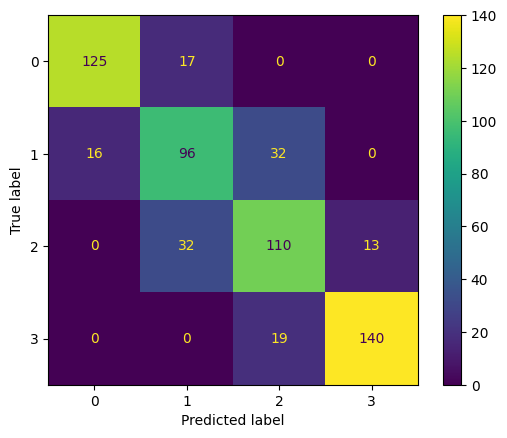

In [53]:
nb_cm = confusion_matrix(y_val, y_pred_nb_scikit)
disp = ConfusionMatrixDisplay(nb_cm)
disp.plot()
plt.show()

In [54]:
acc = np.sum(y_val == y_pred_nb_scikit)/len(y_val)
print(f"Accuracy Percentage {np.round(acc*100,2)}")

Accuracy Percentage 78.5


### Saving Model

In [55]:
joblib.dump(scikit_nb, "/kaggle/working/scikit_naive_bayes.pkl")

['/kaggle/working/scikit_naive_bayes.pkl']

# Submission

In [56]:
transformed_column_names = ['battery_power', 'ram', 'px_width','px_height']

In [57]:
pipeline = Pipeline([
#     ('removing outliers', OutlierRemoval()),
    ('invalid data replacement', InvalidReplacement()),
#     ('area calculation', PixelAreaCalculator()),
    ('feature selection', DropColumn(non_numeric_columns + remove_col))
])

full_pipeline = Pipeline([
    ('preprocessor', pipeline),
#     ('scaling', numericTransformation)
])

In [58]:
id_test = test_df['id']

In [59]:
prep_test_df = test_df.drop(columns=["id"])
prep_test_df

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1076,1,2.2,0,3,1,53,0.1,114,6,6,127,1314,1003,16,9,10,1,0,0
1,1310,0,2.4,0,0,0,40,0.5,118,5,0,1499,1687,3348,9,2,13,0,0,1
2,1915,0,1.1,0,6,0,30,0.6,181,3,8,266,1754,3815,13,4,7,0,0,0
3,587,0,1.4,0,9,1,8,0.5,142,7,13,128,593,3182,9,7,10,1,0,0
4,1526,0,1.8,0,5,1,11,0.1,131,1,7,150,1606,706,18,7,18,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1841,0,0.9,0,0,1,13,0.6,112,5,3,1311,1679,1645,15,9,12,1,1,1
1996,1064,1,1.8,1,0,0,12,0.3,147,2,5,105,717,1509,16,10,14,0,0,0
1997,1448,0,1.4,1,0,0,22,0.2,142,6,5,345,652,3807,11,7,9,0,0,0
1998,1085,0,2.4,0,3,1,38,0.7,116,6,8,121,905,885,18,4,8,1,0,0


In [60]:
# transformed_column_names.remove('price_range')

In [61]:
test_tf = full_pipeline.fit_transform(prep_test_df)
# test_tf_df = pd.DataFrame(test_tf, columns = numeric_columns)
test_tf_df = test_tf.copy()
# test_tf_df = pd.DataFrame(test_tf, columns =  prep_test_df.columns)
# X_test = test_tf_df.drop(columns=['price_range'])
# X_test = test_tf_df.copy()

In [62]:
test_tf_df

,battery_power,fc,four_g,px_height,px_width,ram,sc_w,talk_time
0,1076,3,1,438.000000,1314,1003,9,10
1,1310,0,0,1499.000000,1687,3348,2,13
2,1915,6,0,584.666667,1754,3815,4,7
3,587,9,1,197.666667,593,3182,7,10
4,1526,5,1,535.333333,1606,706,7,18
...,...,...,...,...,...,...,...,...
1995,1841,0,1,1311.000000,1679,1645,9,12
1996,1064,0,0,239.000000,717,1509,10,14
1997,1448,0,0,345.000000,652,3807,7,9
1998,1085,3,1,301.666667,905,885,4,8


In [63]:
y_submit = knn.predict(test_tf_df)
y_submit

array([0, 3, 3, ..., 3, 0, 3])

In [64]:
y_submit_df =  pd.DataFrame(y_submit, columns=["price_range"])
submit = pd.concat([id_test, y_submit_df], axis = 1)
submit

,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


In [65]:
y_submit_df['price_range'] = y_submit_df['price_range'].astype(int)
submit = pd.concat([id_test, y_submit_df], axis=1)

In [66]:
submit['price_range'].value_counts()

price_range
0    507
1    503
2    496
3    494
Name: count, dtype: int64

In [67]:
submit.to_csv('submission_21.csv', index=False)